In [31]:
# MAIN TODO:
#     - put validation set as early stopping DONE 
#     - show loss functions decrease through epochs (train, test and val) DONE 
#     - show correct and incorrect predictions DONE  
#     - can modify the layers DONE 
#     - put optuna to find best params DONE 
#     
# TOMORROW:
    # - taxas de acuracia por classe plotar DONE 
    # - talvez buscar tbm em relacao a regularizacao e dropout DONE   
    # - descrever a parte passo a passo depois optuna 
    # - colocar no colab 
    

# aninha melhor:
# {'accuracy': 0.5393, 'balanced_accuracy': np.float64(0.5393), 'precision': 0.5331819635272109, 'recall': 0.5393, 'f1_score': 0.5336478703066184}

# Imports

In [32]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 
from optuna.trial import Trial

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

# Helper functions and MLP class

In [33]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function, dropout_rate, use_batch_norm=True):
        super(MLP, self).__init__()
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p=dropout_rate)
        self.use_batch_norm = use_batch_norm

        layers_dims = [input_size] + hidden_layers + [num_classes]
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(len(layers_dims) - 1):  
            self.layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
            
            if use_batch_norm and i < len(layers_dims) - 2:
                self.batch_norms.append(nn.BatchNorm1d(layers_dims[i+1]))



    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
            x = self.dropout(x)

        x = self.layers[-1](x)
        
        return x 

In [34]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512)

    # reg params
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

    n_layers = trial.suggest_int('n_layers', 2, 7)
    hidden_layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256)
        hidden_layers.append(n_units)

    input_size = 32*32*3
    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    model = MLP(
        input_size=input_size,
        hidden_layers=hidden_layers,
        num_classes=num_classes,
        activation_function=activation_function,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for _ in range(20):
        model.train()
        for images, labels in train_loader:
            images = images.view(-1, input_size).cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval() # disable dropout just to validate
        val_loss = evaluate_model(model, val_loader, loss_function)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_loss


# Setup

In [35]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [36]:
# just to run fast
subset_sample      = 1000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [37]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [38]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [39]:
n_trials=1
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-01 08:35:56,256] A new study created in memory with name: no-name-ff9ac782-880e-49f9-bd6c-459d77176f19
[I 2025-06-01 08:35:59,008] Trial 0 finished with value: 1.9910516142845154 and parameters: {'activation': 'Sigmoid', 'learning_rate': 0.005330388100730396, 'batch_size': 89, 'dropout_rate': 0.4671938085027636, 'weight_decay': 0.001083438096933287, 'use_batch_norm': True, 'n_layers': 3, 'n_units_l0': 114, 'n_units_l1': 49, 'n_units_l2': 158}. Best is trial 0 with value: 1.9910516142845154.


## Best founded model

In [40]:
study.best_params

{'activation': 'Sigmoid',
 'learning_rate': 0.005330388100730396,
 'batch_size': 89,
 'dropout_rate': 0.4671938085027636,
 'weight_decay': 0.001083438096933287,
 'use_batch_norm': True,
 'n_layers': 3,
 'n_units_l0': 114,
 'n_units_l1': 49,
 'n_units_l2': 158}

In [41]:
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(study.best_params['n_layers'])]

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

best_activation = activation_functions[study.best_params['activation']]

# reg params
dropout_rate=study.best_params['dropout_rate']
use_batch_norm=study.best_params['use_batch_norm']

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [42]:
mlp = MLP(
    input_size=32*32*3,
    hidden_layers=hidden_layers,
    num_classes=10,
    activation_function=best_activation,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm
)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.Adam(mlp.parameters(), 
                             lr=study.best_params['learning_rate'], 
                             weight_decay=study.best_params['weight_decay'])

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    mlp.eval()
    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, val_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break



  0%|          | 2/10000 [00:00<32:09,  5.18it/s]

Epoch 1:
Train Loss: 2.3635
Val Loss: 2.3164
Test Loss: 2.3283
Epoch 2:
Train Loss: 2.3330
Val Loss: 2.2666
Test Loss: 2.2722


  0%|          | 3/10000 [00:00<32:56,  5.06it/s]

Epoch 3:
Train Loss: 2.2594
Val Loss: 2.1816
Test Loss: 2.1889


  0%|          | 4/10000 [00:00<33:18,  5.00it/s]

Epoch 4:
Train Loss: 2.2145
Val Loss: 2.1041
Test Loss: 2.1096


  0%|          | 5/10000 [00:00<33:33,  4.96it/s]

Epoch 5:
Train Loss: 2.1537
Val Loss: 2.0804
Test Loss: 2.0877


  0%|          | 6/10000 [00:01<33:42,  4.94it/s]

Epoch 6:
Train Loss: 2.1355
Val Loss: 2.0823
Test Loss: 2.1044


  0%|          | 7/10000 [00:01<33:58,  4.90it/s]

Epoch 7:
Train Loss: 2.0939
Val Loss: 2.1007
Test Loss: 2.1196


  0%|          | 8/10000 [00:01<34:11,  4.87it/s]

Epoch 8:
Train Loss: 2.1106
Val Loss: 2.0575
Test Loss: 2.0813


  0%|          | 9/10000 [00:01<34:24,  4.84it/s]

Epoch 9:
Train Loss: 2.1026
Val Loss: 2.0545
Test Loss: 2.0784


  0%|          | 10/10000 [00:02<35:40,  4.67it/s]

Epoch 10:
Train Loss: 2.0788
Val Loss: 2.0766
Test Loss: 2.0961


  0%|          | 11/10000 [00:02<35:05,  4.74it/s]

Epoch 11:
Train Loss: 2.0867
Val Loss: 2.0639
Test Loss: 2.0964
Epoch 12:


  0%|          | 13/10000 [00:02<34:06,  4.88it/s]

Train Loss: 2.0705
Val Loss: 2.0368
Test Loss: 2.0617
Epoch 13:
Train Loss: 2.0719
Val Loss: 2.0284
Test Loss: 2.0586


  0%|          | 14/10000 [00:02<34:01,  4.89it/s]

Epoch 14:
Train Loss: 2.0628
Val Loss: 2.0299
Test Loss: 2.0735


  0%|          | 15/10000 [00:03<34:02,  4.89it/s]

Epoch 15:
Train Loss: 2.0537
Val Loss: 2.0347
Test Loss: 2.0460
Epoch 16:
Train Loss: 2.0306


  0%|          | 17/10000 [00:03<33:31,  4.96it/s]

Val Loss: 2.0051
Test Loss: 2.0467
Epoch 17:
Train Loss: 2.0680
Val Loss: 2.0212
Test Loss: 2.0302


  0%|          | 18/10000 [00:03<33:29,  4.97it/s]

Epoch 18:
Train Loss: 2.0439
Val Loss: 2.0241
Test Loss: 2.0382


  0%|          | 19/10000 [00:03<33:30,  4.97it/s]

Epoch 19:
Train Loss: 2.0261
Val Loss: 2.0378
Test Loss: 2.0675


  0%|          | 20/10000 [00:04<33:57,  4.90it/s]

Epoch 20:
Train Loss: 2.0371
Val Loss: 2.0086
Test Loss: 2.0279


  0%|          | 21/10000 [00:04<34:09,  4.87it/s]

Epoch 21:
Train Loss: 2.0128
Val Loss: 1.9923
Test Loss: 2.0200


  0%|          | 22/10000 [00:04<34:15,  4.85it/s]

Epoch 22:
Train Loss: 2.0328
Val Loss: 1.9858
Test Loss: 2.0037


Epoch 23:
Train Loss: 2.0061
Val Loss: 2.0051
Test Loss: 2.0400


  0%|          | 24/10000 [00:05<33:48,  4.92it/s]

Epoch 24:
Train Loss: 2.0007
Val Loss: 1.9794
Test Loss: 1.9996
Epoch 25:
Train Loss: 2.0090


  0%|          | 26/10000 [00:05<33:26,  4.97it/s]

Val Loss: 1.9893
Test Loss: 2.0134
Epoch 26:
Train Loss: 1.9890
Val Loss: 1.9734
Test Loss: 2.0054


  0%|          | 27/10000 [00:05<33:29,  4.96it/s]

Epoch 27:
Train Loss: 1.9927
Val Loss: 1.9730
Test Loss: 1.9863


  0%|          | 28/10000 [00:05<33:46,  4.92it/s]

Epoch 28:
Train Loss: 1.9637
Val Loss: 1.9620
Test Loss: 1.9921


  0%|          | 29/10000 [00:05<33:55,  4.90it/s]

Epoch 29:
Train Loss: 1.9411
Val Loss: 1.9696
Test Loss: 2.0027


  0%|          | 30/10000 [00:06<33:46,  4.92it/s]

Epoch 30:
Train Loss: 2.0114
Val Loss: 1.9738
Test Loss: 1.9953


  0%|          | 31/10000 [00:06<33:41,  4.93it/s]

Epoch 31:
Train Loss: 1.9980
Val Loss: 1.9897
Test Loss: 2.0087


  0%|          | 32/10000 [00:06<33:35,  4.95it/s]

Epoch 32:
Train Loss: 1.9460
Val Loss: 1.9706
Test Loss: 2.0101


Epoch 33:
Train Loss: 1.9765
Val Loss: 1.9500
Test Loss: 1.9857
Epoch 34:


  0%|          | 34/10000 [00:06<33:29,  4.96it/s]

Train Loss: 1.9683
Val Loss: 1.9750
Test Loss: 1.9958


  0%|          | 35/10000 [00:07<33:31,  4.95it/s]

Epoch 35:
Train Loss: 1.9540
Val Loss: 1.9617
Test Loss: 1.9887


  0%|          | 36/10000 [00:07<33:29,  4.96it/s]

Epoch 36:
Train Loss: 1.9652
Val Loss: 1.9745
Test Loss: 1.9898


  0%|          | 37/10000 [00:07<33:39,  4.93it/s]

Epoch 37:
Train Loss: 2.0000
Val Loss: 1.9640
Test Loss: 1.9854


  0%|          | 37/10000 [00:07<34:41,  4.79it/s]

Epoch 38:
Train Loss: 2.0049
Val Loss: 1.9642
Test Loss: 1.9859
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

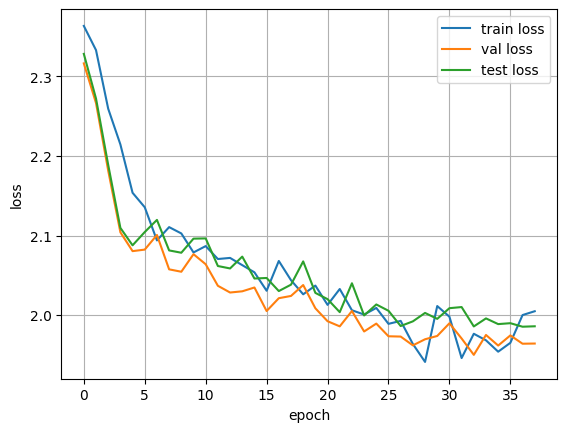

In [43]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

/tmp/ipykernel_7142/1788698865.py:86: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(h_pad=2)


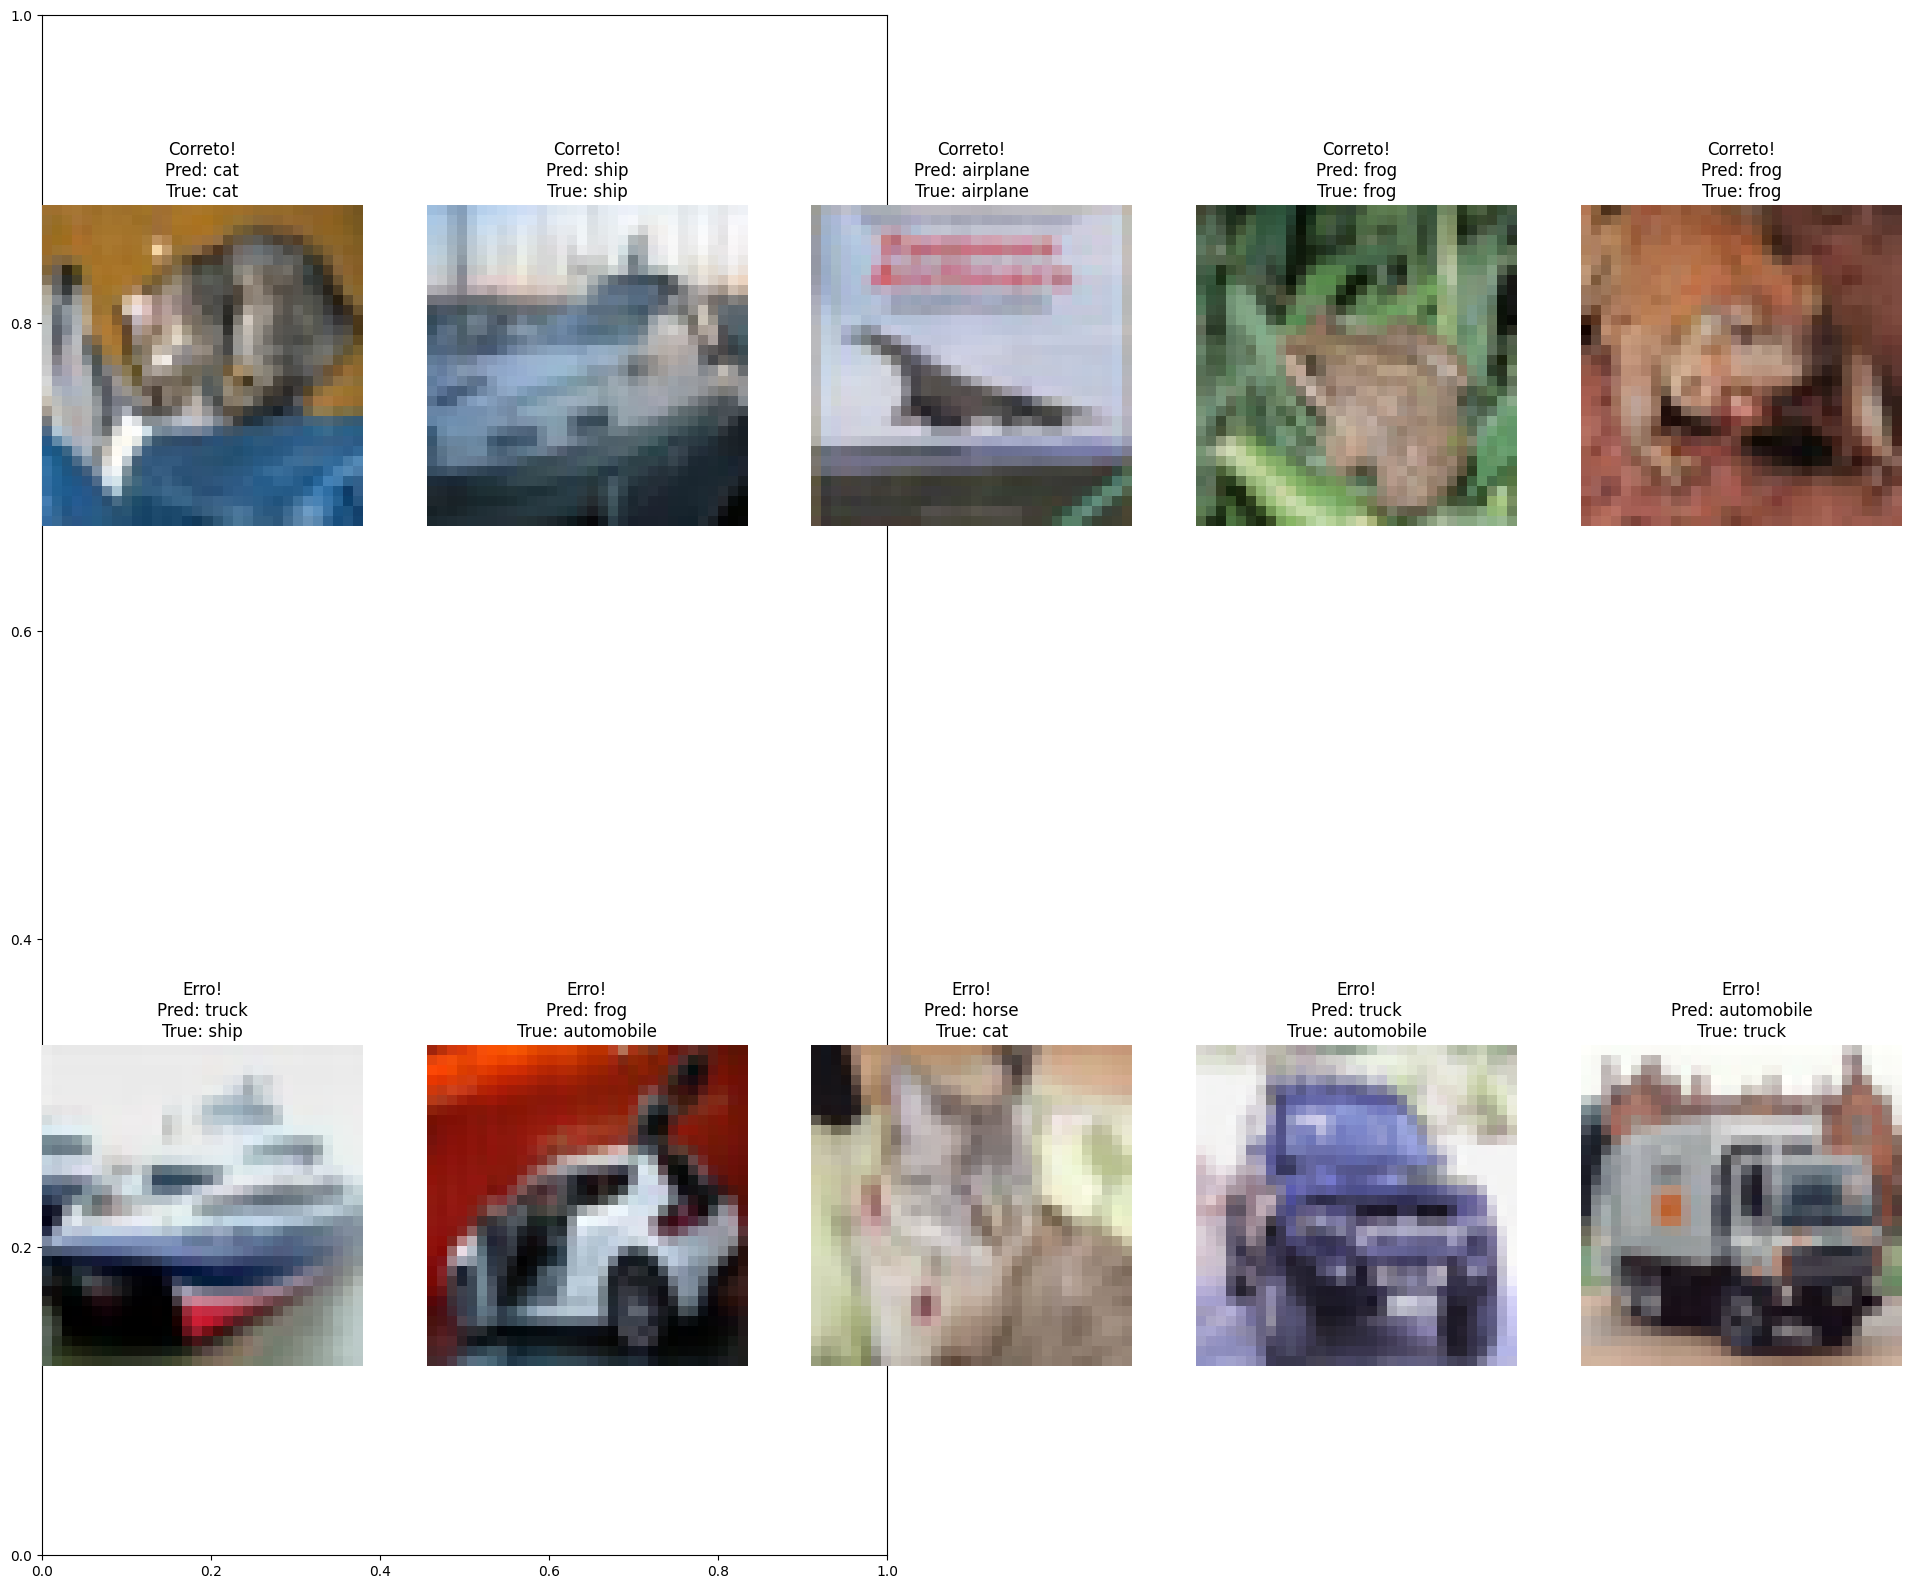

In [45]:
show_predictions(mlp, test_loader, num_samples=5)

In [46]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.249, 'balanced_accuracy': np.float64(0.24220544311866138), 'f1_score': 0.20311749233445373, 'precision': 0.19627024283756925, 'recall': 0.249}




/home/eduardoamorim/Área de trabalho/cin_2025_1/NN/nn-exps/.venvNN/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'] # .venvNN/lib/python3.12/site-packages/torchvision/prototype/datasets/_builtin/cifar10.categories

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 1000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 38.83%
  Número de amostras: 103
  Representatividade: 10.30%

automobile:
  Acurácia: 51.69%
  Número de amostras: 89
  Representatividade: 8.90%

bird:
  Acurácia: 0.00%
  Número de amostras: 100
  Representatividade: 10.00%

cat:
  Acurácia: 15.53%
  Número de amostras: 103
  Representatividade: 10.30%

deer:
  Acurácia: 0.00%
  Número de amostras: 90
  Representatividade: 9.00%

dog:
  Acurácia: 3.49%
  Número de amostras: 86
  Representatividade: 8.60%

frog:
  Acurácia: 66.07%
  Número de amostras: 112
  Representatividade: 11.20%

horse:
  Acurácia: 28.43%
  Número de amostras: 102
  Representatividade: 10.20%

ship:
  Acurácia: 19.81%
  Número de amostras: 106
  Representatividade: 10.60%

truck:
  Acurácia: 18.35%
  Número de amostras: 109
  Representatividade: 10.90%
